In [1]:
'''
5conv層を追加学習
'''

'\n5conv層を追加学習\n'

In [1]:
import sys, os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

from tensorflow.keras.utils import img_to_array
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.applications.vgg16 import VGG16

In [2]:
train_dir = "/Users/taikisakai/Documents/projects/fracture_mode_detection/dataset_wide_range"
test_dir = "/Users/taikisakai/Documents/projects/fracture_mode_detection/dataset_wide_range"
img_size = 255
num_classes = 3
class_names = ["ductile", "brittle", "fatigue", "intergranular"]


In [3]:
augment = keras.Sequential(
    [layers.RandomFlip("horizontal_and_vertical"), 
     layers.RandomRotation(0.2)]
)

2024-10-12 21:10:07.859418: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-10-12 21:10:07.859439: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-12 21:10:07.859444: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-12 21:10:07.859468: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-12 21:10:07.859480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
data_dir = "/Users/taikisakai/Documents/projects/fracture_mode_detection/dataset_wide_range"
INPUT_TFRECORD_TRAIN = os.path.join(data_dir, "train.tfrecords")
INPUT_TFRECORD_TEST = os.path.join(data_dir, "test.tfrecords")

In [5]:
class LoadTfrecords:

    def __init__(self, BATCH_SIZE):
        self.BATCH_SIZE = BATCH_SIZE


    def parse_train(self, serialized):
        features = {"image": tf.io.FixedLenFeature([], tf.string), 
                    "label": tf.io.FixedLenFeature([], tf.string)}
        
        parsed = tf.io.parse_single_example(serialized=serialized, 
                                            features=features)
        
        image_raw = parsed["image"]
        label_raw = parsed["label"]

        images = tf.io.decode_raw(image_raw, tf.uint8)
        images = tf.cast(images, tf.float32) / 255
        images = tf.reshape(images, [254, 254, 3])

        labels = tf.io.decode_raw(label_raw, tf.uint8)
        labels = tf.reshape(labels, [4])

        return images, labels
    

    def parse_test(self, serialized):
        features = {"image": tf.io.FixedLenFeature([], tf.string), 
                    "label": tf.io.FixedLenFeature([], tf.string)}
        
        parsed = tf.io.parse_single_example(serialized=serialized, 
                                            features=features)
        
        image_raw = parsed["image"]
        label_raw = parsed["label"]

        images = tf.io.decode_raw(image_raw, tf.uint8)
        images = tf.cast(images, tf.float32) / 255
        images = tf.reshape(images, [254, 254, 3])

        labels = tf.io.decode_raw(label_raw, tf.uint8)
        labels = tf.reshape(labels, [4])

        return images, labels


In [6]:
parse_data = LoadTfrecords(BATCH_SIZE=32)

trainset = tf.data.TFRecordDataset(INPUT_TFRECORD_TRAIN)
trainset = trainset.map(parse_data.parse_train)
trainset = trainset.shuffle(buffer_size=1022)
trainset = trainset.repeat(-1)
trainset = trainset.batch(32)
trainset = trainset.prefetch(buffer_size=4)

testset = tf.data.TFRecordDataset(INPUT_TFRECORD_TEST)
testset = testset.map(parse_data.parse_test)
testset = testset.batch(32)
testset = testset.prefetch(buffer_size=208)

In [7]:
input = Input(shape=(254, 254, 3))
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input)

In [8]:
x = base_model.output
x = Flatten(input_shape=base_model.output_shape[1:])(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(4, activation='softmax')(x)
model = keras.models.Model(inputs=base_model.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 254, 254, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 254, 254, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 254, 254, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 63, 63, 128)       0     

In [9]:
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 254, 254, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 254, 254, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 254, 254, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 63, 63, 128)       0     

In [11]:
for layer in base_model.layers:
    print(layer, layer.trainable)

print('=' * 100)

for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x308d44b50> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x308d44940> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x3098041c0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x30c6fafd0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x30c6d9970> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x30c6fad00> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x30c728670> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x30c6fadf0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x30c728dc0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x30c728550> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x30c548100> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x30c548a90> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x30c549b50> False
<keras.sr

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 254, 254, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 254, 254, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 254, 254, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 63, 63, 128)       0     

In [13]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=["acc"])

In [14]:
history = model.fit(trainset, 
                    steps_per_epoch=1022//64, 
                    epochs=50, 
                    validation_data=testset)

Epoch 1/50


2024-10-12 21:10:12.651116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 10s 615ms/step - loss: 1.6526 - acc: 0.3292 - val_loss: 0.9931 - val_acc: 0.6587
Epoch 2/50


2024-10-12 21:10:22.022810: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6003709007922256305
2024-10-12 21:10:22.022822: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15549027334505217497
2024-10-12 21:10:22.022825: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7279176999444110773
2024-10-12 21:10:22.022828: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11606686674961123249
2024-10-12 21:10:22.022837: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1847598487435418212


15/15 [==============================] - 9s 618ms/step - loss: 0.9922 - acc: 0.5896 - val_loss: 0.5678 - val_acc: 0.8654
Epoch 3/50
15/15 [==============================] - 9s 609ms/step - loss: 0.5464 - acc: 0.7937 - val_loss: 0.3266 - val_acc: 0.8942
Epoch 4/50
15/15 [==============================] - 9s 610ms/step - loss: 0.2931 - acc: 0.9000 - val_loss: 0.2199 - val_acc: 0.9279
Epoch 5/50
15/15 [==============================] - 9s 610ms/step - loss: 0.1910 - acc: 0.9417 - val_loss: 0.1740 - val_acc: 0.9423
Epoch 6/50
15/15 [==============================] - 9s 610ms/step - loss: 0.1640 - acc: 0.9458 - val_loss: 0.1469 - val_acc: 0.9567
Epoch 7/50
15/15 [==============================] - 9s 610ms/step - loss: 0.0872 - acc: 0.9792 - val_loss: 0.1328 - val_acc: 0.9519
Epoch 8/50
15/15 [==============================] - 9s 610ms/step - loss: 0.0636 - acc: 0.9854 - val_loss: 0.1228 - val_acc: 0.9423
Epoch 9/50
15/15 [==============================] - 9s 613ms/step - loss: 0.0689 - acc:

(1.0, 50.0)

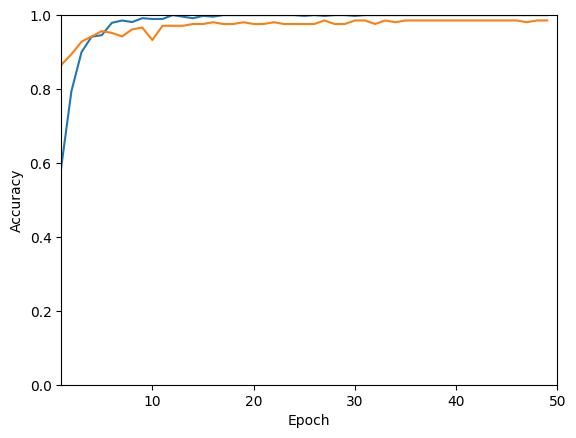

In [31]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.xlim([1, 50])

(1.0, 50.0)

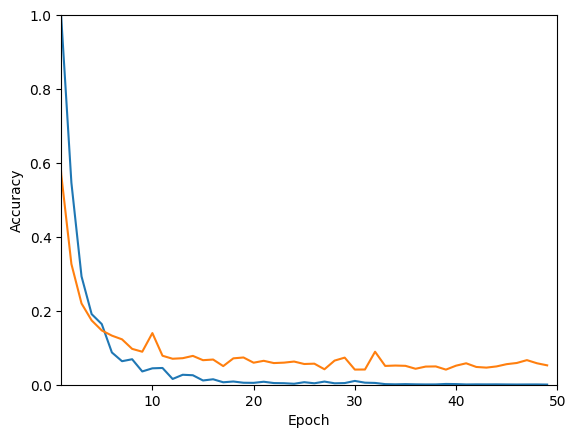

In [32]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.xlim([1, 50])

In [30]:
model.save('4classes_model_conv5.h5')

/Users/taikisakai/miniforge3/envs/tf-macos/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
eval = model.evaluate(testset)

7/7 [==============================] - 3s 337ms/step - loss: 0.0525 - acc: 0.9856


2024-10-12 21:18:21.973522: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6003709007922256305
2024-10-12 21:18:21.973532: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15549027334505217497
2024-10-12 21:18:21.973536: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7279176999444110773
2024-10-12 21:18:21.973539: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11606686674961123249
2024-10-12 21:18:21.973545: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1847598487435418212


In [18]:
model_pred = model.predict(testset)

7/7 [==============================] - 3s 397ms/step


2024-10-12 21:18:28.692553: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14558145458612923652


In [19]:
y_prediction = np.argmax (model_pred, axis = 1)
print(y_prediction)

[0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [20]:
label_list = []
num_list = [0, 1, 2, 3]
for index in num_list:
    for i in range(52):
      label_list.append(index)

In [21]:
print(label_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [22]:
array_list = []
for i in label_list:
    array_list.append([i])

In [23]:
print(array_list)

[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3],

In [24]:
test_labels_onehot = np.eye(4).astype(np.uint8)[array_list]

In [25]:
print(test_labels_onehot)

[[[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[1 0 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1

In [26]:
label_list = test_labels_onehot.argmax(axis=-1)
print(label_list)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]


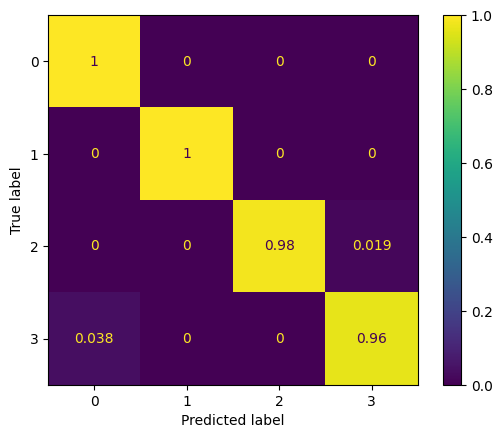

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matrix = confusion_matrix(y_prediction, label_list, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.show()